Pricing Hedge agent interacting with a non-stationary (adverarial) full feedback environment 

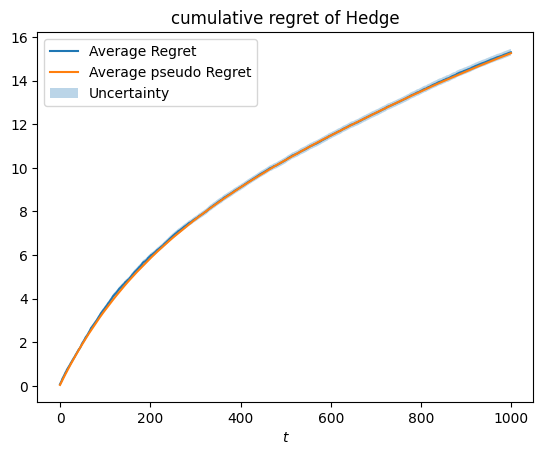

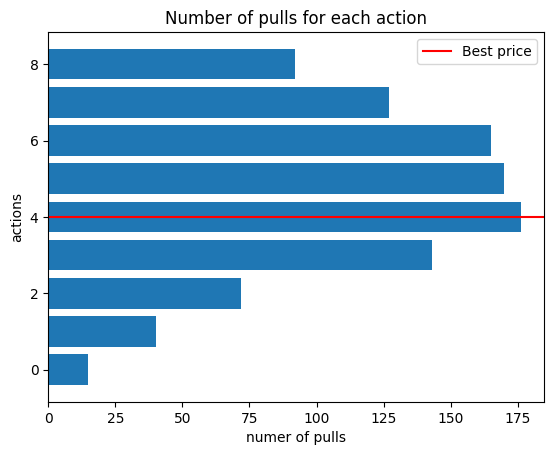

In [5]:
from pricing_environment import PricingEnvironment
from bidding import HedgeAgent
from Demand_curve_generator import Demand_curve_generator as demand

from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


n_trials = 50

regret_per_trial = []
pseudo_regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    T = 1000 # number of days
    epsilon = T**(-0.33)
    K =  int(1/epsilon)# number of actions (see theory for the choice of K)
    n_customers = 100 #this would depend on advertising step
    learning_rate = np.sqrt(np.log(K)/T)


    prices = np.linspace(0,1,K) # 100 actions
    cost = 0.1 #To be chosen

    conversion_rates = []
    random_steeps = np.random.uniform(1,5,T) #generates T parameters for the demand curve 1 for each day (ask if it could be more than one per day)
    conversion_rates = [demand.generate_demand(0,1,steep) for steep in random_steeps]

    reward_function = lambda price, n_sales: (price-cost)*n_sales
    maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


    loss_profit_curve = []
    for t in range(T):
        loss_profit_curve.append([(1-(price-cost)*conversion_rates[t](price)) for price in prices])
    loss_profit_curve = np.array(loss_profit_curve)
    summed_losses = np.sum(loss_profit_curve, axis=0)
    best_price_index = np.argmin(summed_losses)
    best_price = prices[best_price_index]
    expected_clairvoyant_losses = loss_profit_curve[:,best_price_index]

    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_rates, cost=cost, prices=prices)
    Hedge_agent = HedgeAgent(K, learning_rate)

    agent_losses = np.array([])
    expected_agent_losses = np.array([])


    for t in range(T):
        pi_t = Hedge_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        l_t, r_t, d_t = env.round(p_t, n_customers, t)
        Hedge_agent.update(l_t)

        agent_losses = np.append(agent_losses, l_t[pi_t])
        expected_agent_losses = np.append(expected_agent_losses, np.dot(l_t, Hedge_agent.x_t))


    cumulative_regret = np.cumsum(agent_losses-expected_clairvoyant_losses)
    cumulative_pseudo_regret = np.cumsum(expected_agent_losses-expected_clairvoyant_losses)

    regret_per_trial.append(cumulative_regret)
    pseudo_regret_per_trial.append(cumulative_pseudo_regret)

regret_per_trial = np.array(regret_per_trial)
pseudo_regret_per_trial = np.array(pseudo_regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
average_pseudo_regret = pseudo_regret_per_trial.mean(axis=0)
pseudo_regret_std = pseudo_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.plot(np.arange(T), average_pseudo_regret, label='Average pseudo Regret')
plt.title('cumulative regret of Hedge')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), Hedge_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();